In [5]:
!pip install pandas==1.5.3

In [61]:
# Gradient Boosting Classifier for Loan Default Prediction

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.utils import class_weight

# Set global random seed for reproducibility
np.random.seed(42)

# Load DataFrame and column lists from pickle
import pickle
with open("lending_club_dataset.pickle", "rb") as f:
    data_list = pickle.load(f)

data = data_list[0]  # The main DataFrame
categorical_cols = data_list[1]
continuous_cols = data_list[2]

Missing Value Summary:
emp_length    37891
dtype: int64
Column Names:
['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt', 'last_pymnt_d', 'recoveries', 'loan_length', 'term_num', 'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc']
Dataset Sample:
         id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  40390412     5000.0       5000.0   36 months     12.39       167.01     C   
2  40401108    17000.0      17000.0   36 months     12.39       567.82     C   
3  40501689     9000.0       9000.0   36 months     14.31       308.96     C   
4  40352737    14000.0      14000.0   36 months     11.99       464.94     B   
5  40431323    10000.0      10000.0   60 months     19.24       260.7

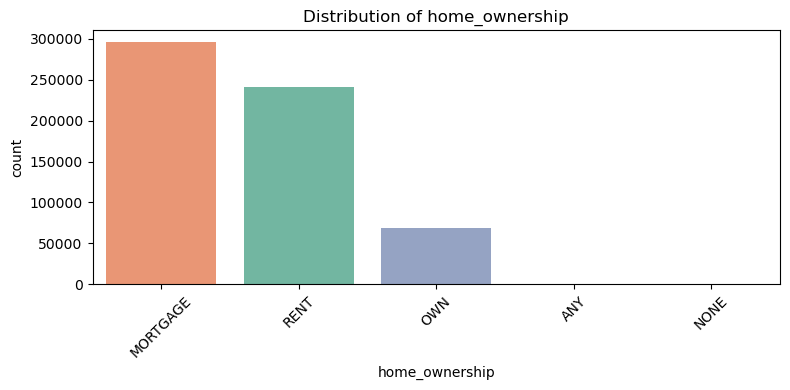

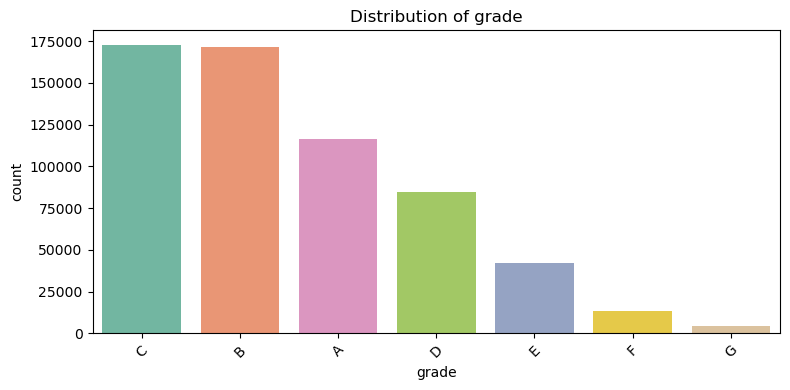

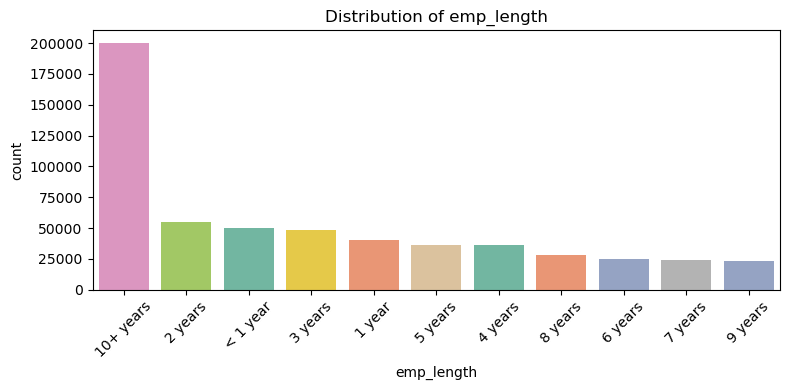

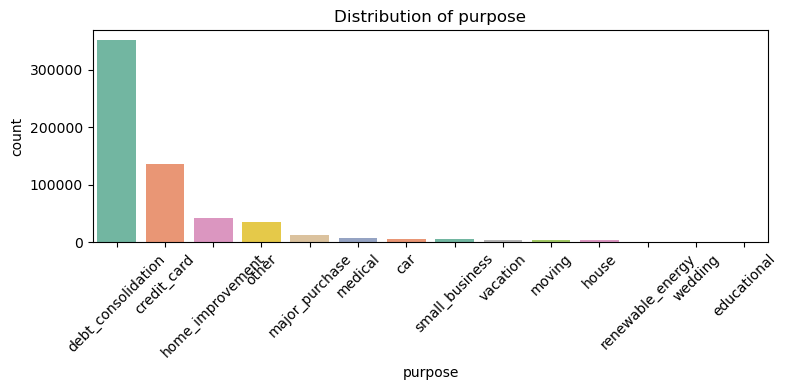

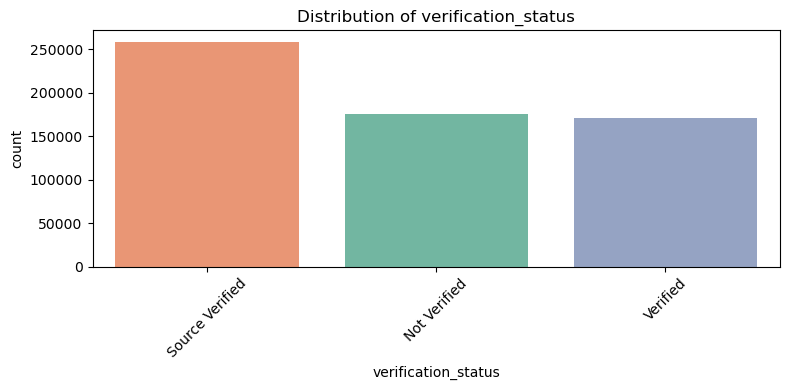

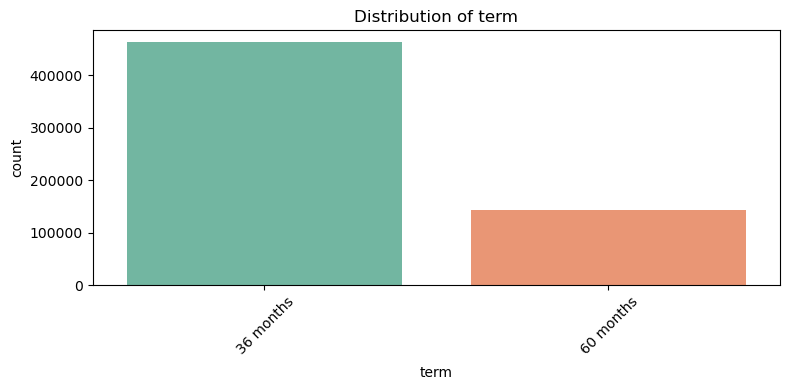

Grade-Level Loan Summary:
   % of Loans   int_rate   ret_OPT  default_%
A   19.184339   6.877237  3.689253   6.123802
B   28.356520  10.150223  4.479752  14.233120
C   28.562674  13.576124  4.829701  23.923868
D   14.029674  17.389625  5.001841  33.344323
E    6.990885  20.601166  5.192297  42.090215
F    2.179810  24.977874  5.493961  50.545620
G    0.696099  28.598315  5.473099  54.247746


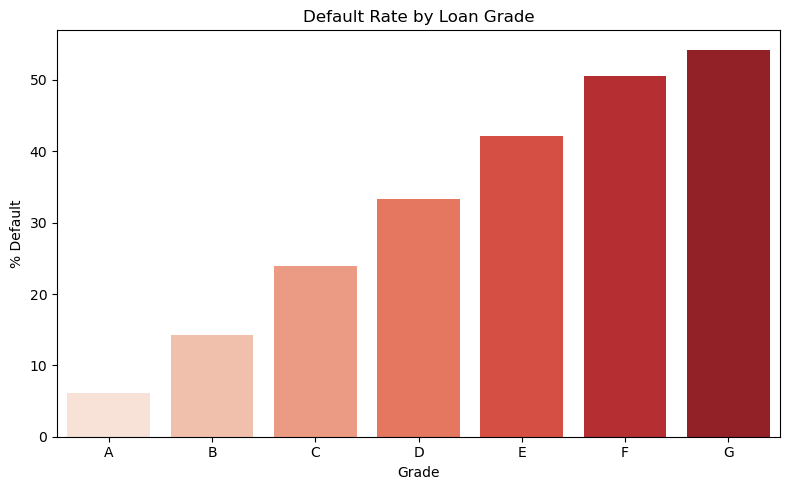

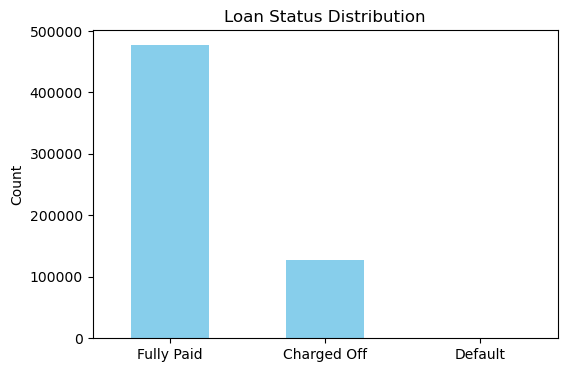

Summary Statistics:
                    count          mean           std      min         25%  \
loan_amnt        605374.0  14552.362506   8795.106114  1000.00   8000.0000   
funded_amnt      605374.0  14552.362506   8795.106114  1000.00   8000.0000   
installment      605374.0    439.151480    262.995589    14.01    248.4425   
annual_inc       605374.0  76879.932932  72778.816918    16.00  45712.7500   
dti              605374.0     18.969691     11.783039    -1.00     12.1900   
revol_bal        605374.0  16578.285790  23590.032714     0.00   5856.0000   
delinq_2yrs      605374.0      0.338577      0.920335     0.00      0.0000   
open_acc         605374.0     11.846685      5.676809     1.00      8.0000   
pub_rec          605374.0      0.239870      0.641496     0.00      0.0000   
fico_range_high  605374.0    699.438314     31.856039   664.00    674.0000   
fico_range_low   605374.0    695.438159     31.855308   660.00    670.0000   
int_rate         605374.0     12.698760     

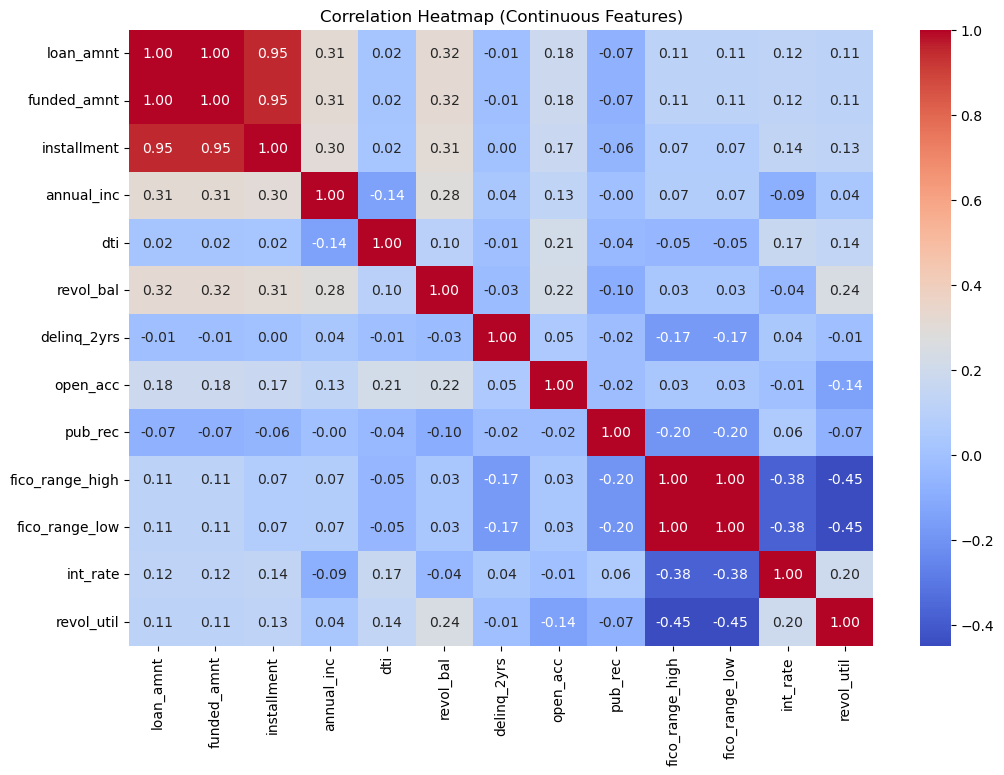

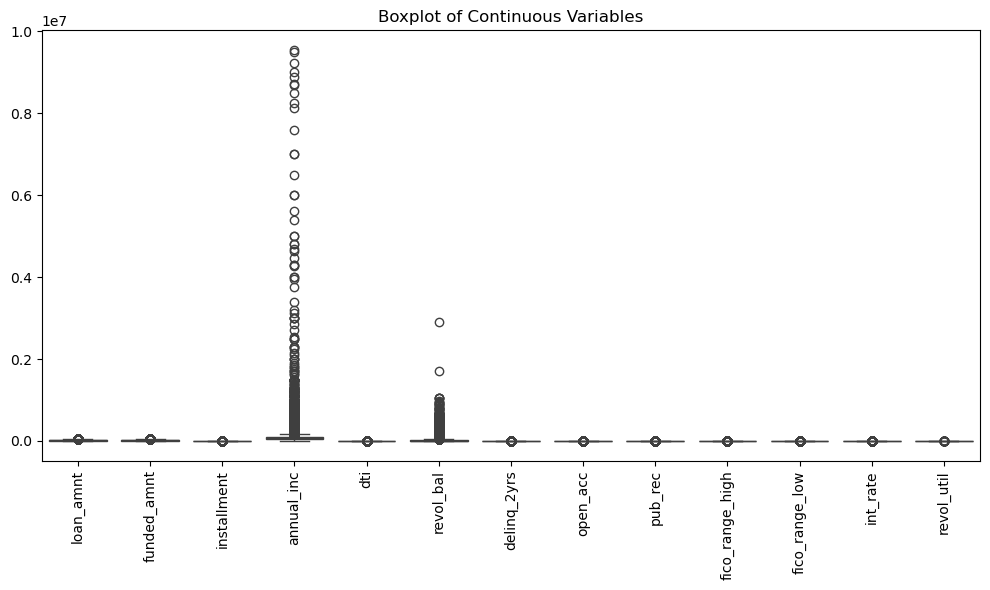

In [9]:
# =======================
# 1. Exploratory Data Analysis (EDA)
# =======================

# Basic structural overview

# Check for missing values (explicit check)
missing_values = data.isnull().sum()
missing_summary = missing_values[missing_values > 0].sort_values(ascending=False)
print("Missing Value Summary:")
print(missing_summary)
print("Column Names:")
print(data.columns.tolist())

print("Dataset Sample:")
print(data.head())

print(f"Total rows: {len(data)}")
print(f"Total columns: {len(data.columns)}")

# Summary of loan amounts
print("Loan Amount Summary:")
print(data['loan_amnt'].describe())

# Countplots for Categorical Features
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue=col, data=data, order=data[col].value_counts().index, palette='Set2', legend=False)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Grade-level summary statistics
# -----------------------------------

# Percentage of loans by grade
perc_by_grade = (data.grade.value_counts() * 100 / len(data)).sort_index()

# Average interest rate and return_1 by grade
int_rate_by_grade = data.groupby("grade").apply(lambda x: np.mean(x.int_rate))
ret_by_grade_OPT = data.groupby("grade").apply(lambda x: np.mean(x.ret_OPT) * 100)

# Percentage of defaulted loans by grade
default_by_grade = data.groupby("grade").apply(lambda x: (x.loan_status.isin(["Charged Off", "Default"]).sum() * 100 / len(x)))

# Combine into one DataFrame
combined = pd.DataFrame(perc_by_grade)
combined.columns = ['% of Loans']
combined['int_rate'] = int_rate_by_grade
combined['ret_OPT'] = ret_by_grade_OPT
combined['default_%'] = default_by_grade

print("Grade-Level Loan Summary:")
print(combined)

# Bar plot of default rate by grade
plt.figure(figsize=(8,5))
sns.barplot(x=combined.index, y=combined['default_%'], hue=combined.index, palette='Reds', legend=False)
plt.title("Default Rate by Loan Grade")
plt.ylabel("% Default")
plt.xlabel("Grade")
plt.tight_layout()
plt.show()

# Target variable distribution
plt.figure(figsize=(6,4))
data['loan_status'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Loan Status Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Summary stats
print("Summary Statistics:")
summary_stats = data[continuous_cols].describe().T
summary_stats['std'] = data[continuous_cols].std()
print(summary_stats)

# Missing values
missing = data.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing values:")
print(missing)

# Correlation matrix
corr_matrix = data[continuous_cols].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap (Continuous Features)")
plt.show()

# Boxplot for outlier visualization
plt.figure(figsize=(10,6))
sns.boxplot(data=data[continuous_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Continuous Variables")
plt.tight_layout()
plt.show()

In [49]:
# =======================
# 2. Data Preprocessing
# =======================

# Remove post-loan outcome variables to prevent data leakage
post_loan_cols = [
    'total_pymnt', 'recoveries', 'last_pymnt_d',
    'ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb', 'ret_INTc'
]
for col in post_loan_cols:
    if col in data.columns:
        data.drop(columns=col, inplace=True)
        if col in continuous_cols:
            continuous_cols.remove(col)

# Fill missing values: continuous with median, categorical with 'Unknown'
for col in continuous_cols:
    data[col] = data[col].fillna(data[col].median())

for col in categorical_cols:
    data[col] = data[col].fillna("Unknown")

# Drop rows with missing target only
data = data.dropna(subset=['loan_status'])

# Convert target variable to binary
# Define default as 'Charged Off' or 'Default'
data['target'] = data['loan_status'].apply(lambda x: 1 if x in ['Charged Off', 'Default'] else 0)

# Ensure 'issue_d' & earliest_cr_line is in datetime format for accurate time-based feature creation
data['issue_d'] = pd.to_datetime(data['issue_d'], errors='coerce')
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'], errors='coerce')

# Create credit history length feature (in months)
data['cr_hist'] = ((data['issue_d'] - data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(float)
continuous_cols.append('cr_hist')

# One-hot encode categorical variables

# Make sure cr_hist is flat again
data['cr_hist'] = ((data['issue_d'] - data['earliest_cr_line']) / np.timedelta64(1, 'M')).astype(float)

# Recheck continuous cols
if 'cr_hist' not in continuous_cols:
    continuous_cols.append('cr_hist')

# Build X_cont carefully — enforce float dtype and flatten all
X_cont = pd.DataFrame({col: data[col].astype(float) for col in continuous_cols})

# Build categorical safely
X_cat = pd.get_dummies(data[categorical_cols], drop_first=True)

# Combine final feature matrix
X = pd.concat([X_cont, X_cat], axis=1)
y = data['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

#Clean and flatten y
if isinstance(y_train, pd.DataFrame):
    y_train = y_train.squeeze()
y_train = y_train.values.ravel()

if isinstance(y_test, pd.DataFrame):
    y_test = y_test.squeeze()
y_test = y_test.values.ravel()

# Ensure clean column names
X_train.columns = X_train.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)
X_test.columns = X_test.columns.astype(str).str.replace(r'[\[\]<>]', '', regex=True)

# Ensure numeric dtype
X_train = X_train.astype(float)
X_test = X_test.astype(float)

# Ensure target is a Series or 1D array
y_train = y_train.values.ravel() if hasattr(y_train, "values") else y_train
y_test = y_test.values.ravel() if hasattr(y_test, "values") else y_test

print(X_train.shape, X_train.dtypes.unique())
print(y_train.shape, type(y_train))

# Run this BEFORE model.fit()
for col in X_train.columns:
    try:
        _ = X_train[col].dtype
    except Exception as e:
        print(f"Column causing error: {col} → {type(X_train[col].iloc[0])} — {e}")

print(type(data['cr_hist'].iloc[0]))

(454030, 51) [dtype('float64')]
(454030,) <class 'numpy.ndarray'>
<class 'numpy.float64'>


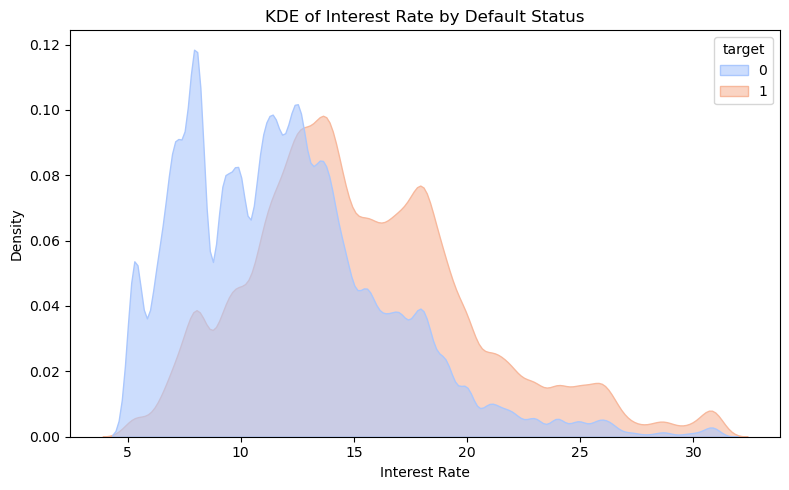

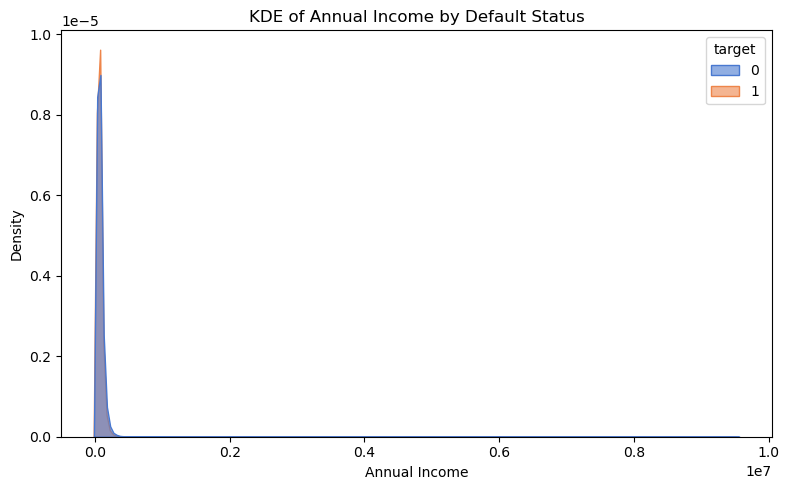

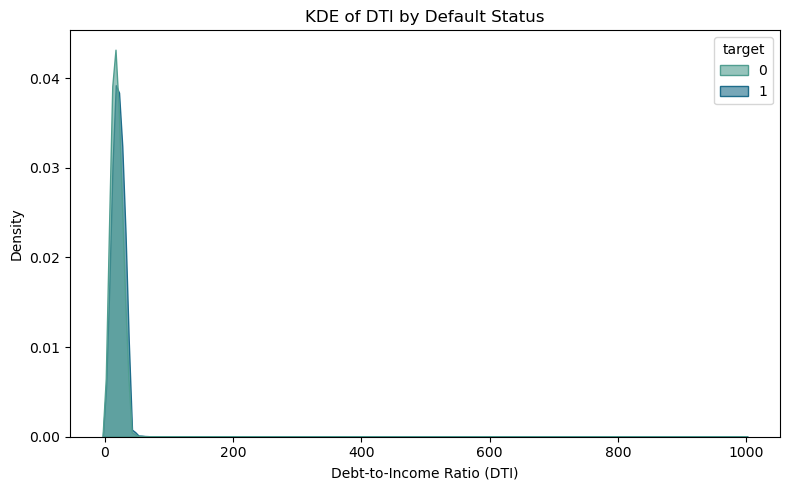

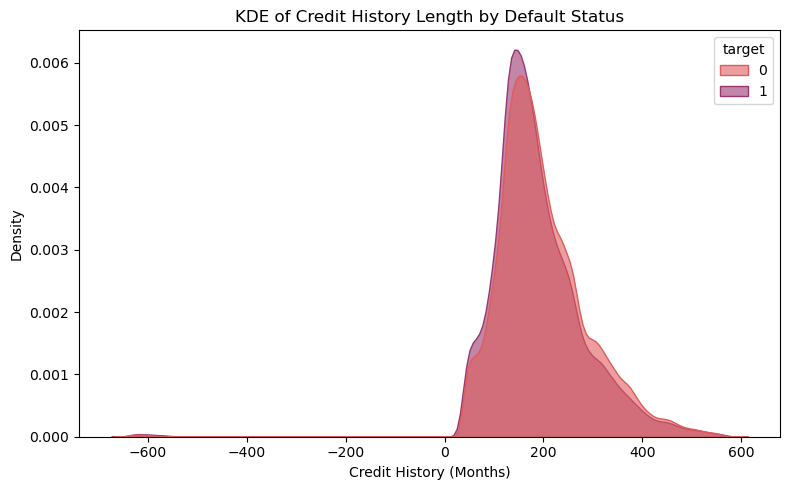

In [7]:
# =======================
# Kernel Density Estimate (KDE) Plot
# =======================

# KDE of interest rate by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='int_rate', hue='target', fill=True, common_norm=False, palette='coolwarm', alpha=0.6)
plt.title('KDE of Interest Rate by Default Status')
plt.xlabel('Interest Rate')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of annual income by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='annual_inc', hue='target', fill=True, common_norm=False, palette='muted', alpha=0.6)
plt.title('KDE of Annual Income by Default Status')
plt.xlabel('Annual Income')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of DTI by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='dti', hue='target', fill=True, common_norm=False, palette='crest', alpha=0.6)
plt.title('KDE of DTI by Default Status')
plt.xlabel('Debt-to-Income Ratio (DTI)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

# KDE of credit history length by default status
plt.figure(figsize=(8,5))
sns.kdeplot(data=data, x='cr_hist', hue='target', fill=True, common_norm=False, palette='flare', alpha=0.6)
plt.title('KDE of Credit History Length by Default Status')
plt.xlabel('Credit History (Months)')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

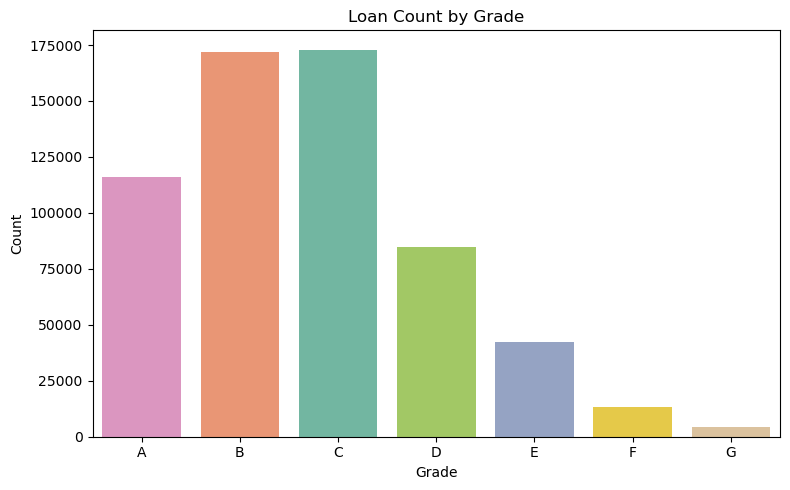

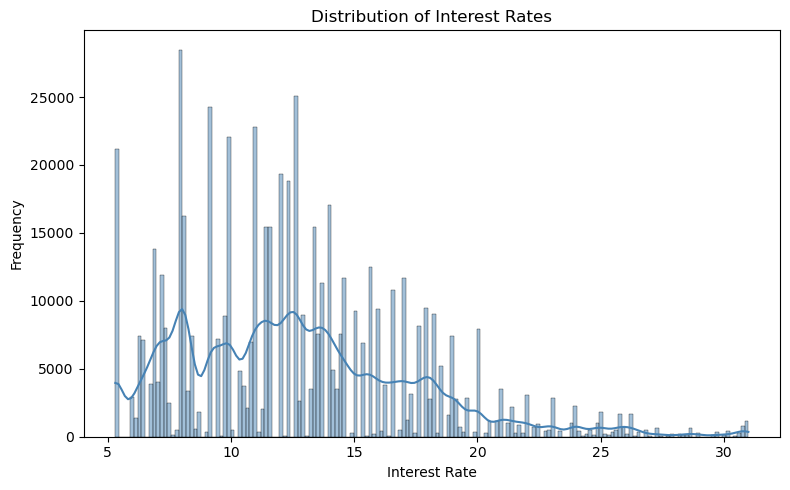

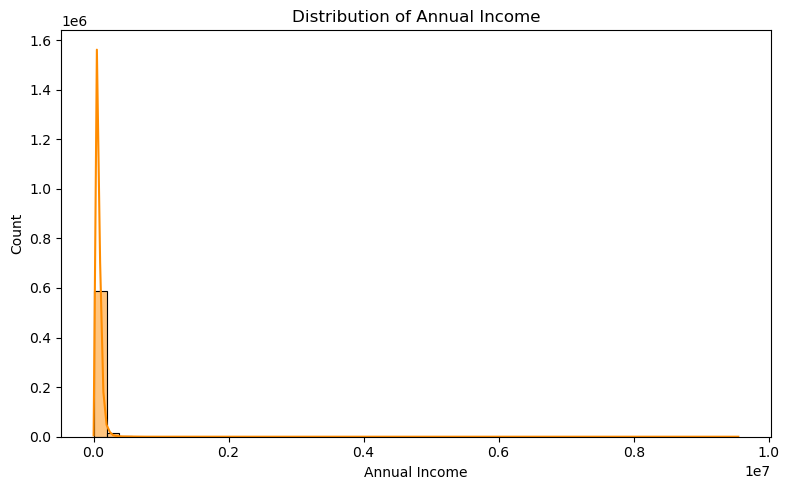

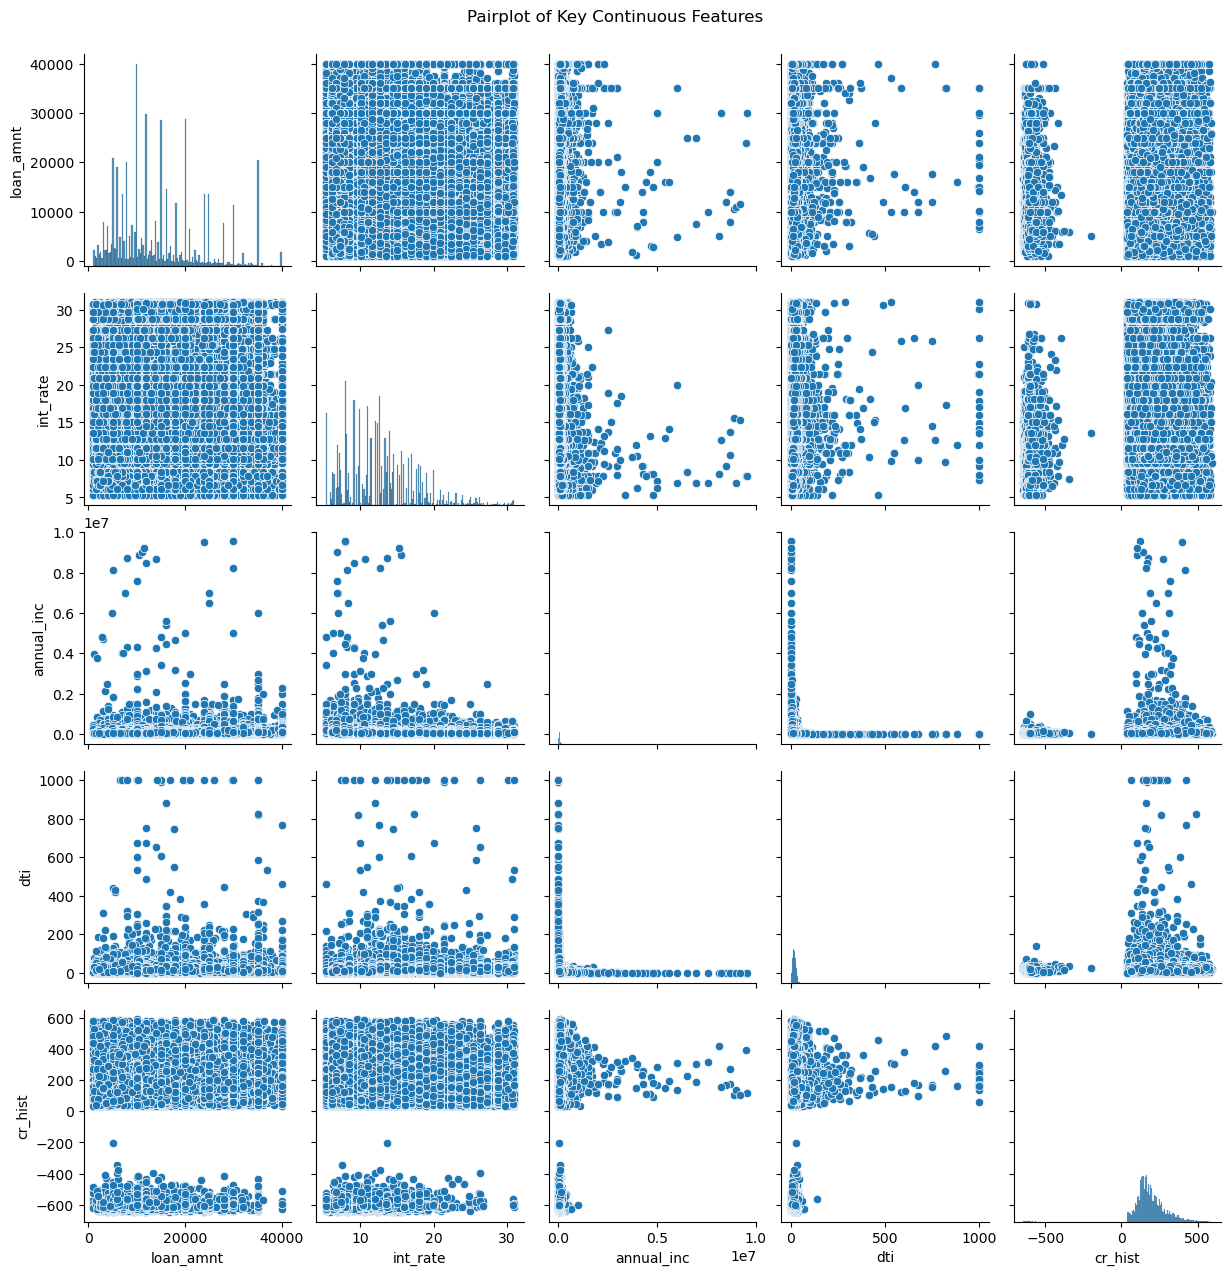

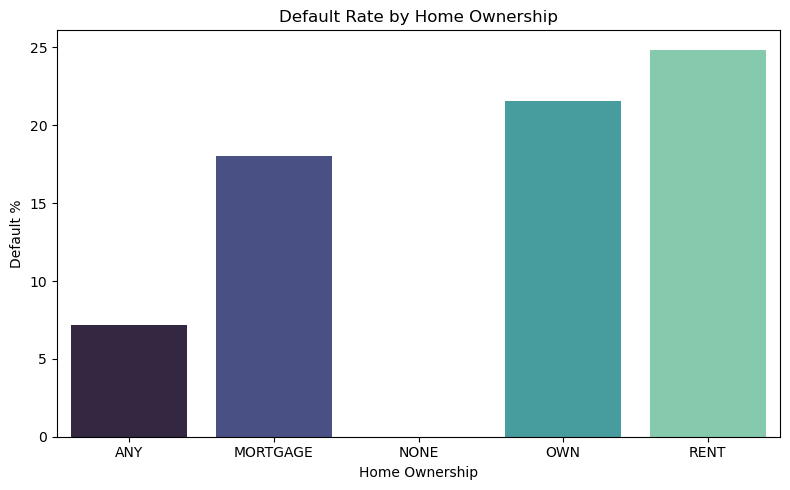

In [9]:
# =======================
# Additional Visual EDA
# =======================

# Countplot of loan grades
plt.figure(figsize=(8,5))
sns.countplot(data=data, x='grade', hue='grade', order=sorted(data['grade'].unique()), palette='Set2', legend=False)
plt.title("Loan Count by Grade")
plt.xlabel("Grade")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Histogram of Interest Rates
plt.figure(figsize=(8,5))
sns.histplot(data['int_rate'], kde=True, color='steelblue')
plt.title("Distribution of Interest Rates")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Histogram of Annual Income
plt.figure(figsize=(8,5))
sns.histplot(data['annual_inc'], bins=50, kde=True, color='darkorange')
plt.title("Distribution of Annual Income")
plt.xlabel("Annual Income")
plt.tight_layout()
plt.show()

# Pairplot of selected continuous features
pairplot_features = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'cr_hist']
sns.pairplot(data[pairplot_features].dropna())
plt.suptitle("Pairplot of Key Continuous Features", y=1.02)
plt.show()

# Bar plot: default rate by home ownership
plt.figure(figsize=(8,5))
default_by_home = data.groupby("home_ownership")["target"].mean() * 100
sns.barplot(x=default_by_home.index, y=default_by_home.values, hue=default_by_home.index, palette='mako', legend=False)
plt.title("Default Rate by Home Ownership")
plt.ylabel("Default %")
plt.xlabel("Home Ownership")
plt.tight_layout()
plt.show()

In [53]:
# =======================
# 3.1 Model Training: XGBoost (Baseline Model without Class Weights)
# =======================

from xgboost import XGBClassifier

baseline_model = XGBClassifier(
    random_state=42,
    n_estimators=100,       # default value
    max_depth=3,            # matches sklearn's default for GBM
    learning_rate=0.1,      # default
    eval_metric='logloss'     # basic eval metric
)

baseline_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [71]:
# =======================
# 3.2 Model Training: XGBoost (Baseline Model with Class Weights)
# =======================

from xgboost import XGBClassifier

# Compute class imbalance ratio for scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

weighted_model = XGBClassifier(
    random_state=42,
    n_estimators=100,       # consistent with baseline
    max_depth=3,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss'   # prevents warning
)

weighted_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [102]:
# =======================
# 3.3 Model Training: XGBoost with Expanded Hyperparameter Tuning (with Class Weights)
# =======================

# Compute class imbalance ratio
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Expanded parameter grid
param_grid = {
    'n_estimators': [100, 200],           # more boosting rounds
    'learning_rate': [0.05, 0.1, 0.2],    # smaller for slower learning
    'max_depth': [3, 5, 7],               # deeper trees capture more interaction
    'subsample': [0.8, 1.0],              # subsample rows to reduce overfitting
    'colsample_bytree': [0.8, 1.0]        # subsample columns to reduce overfitting
}

# Base model setup
xgb_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
)

# Grid search setup
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    verbose=1,
    n_jobs=-1
)

# Train with grid search
grid_search.fit(X_train, y_train)

# Output best model
print("Best parameters found:")
print(grid_search.best_params_)

# Assign best estimator
model = grid_search.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best parameters found:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [104]:
# -----------------------
# 4. Model Evaluation and Validation
# -----------------------

# -----------------------
# 4.1 Three Model Comparison
# -----------------------

# 1. Model 1: Baseline XGBoost (no weights, no tuning)
model1 = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
)
model1.fit(X_train, y_train)
probs1 = model1.predict_proba(X_test)[:, 1]
preds1 = (probs1 >= 0.5).astype(int)

# 2. Model 2: Weighted XGBoost (class weights, no tuning)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
model2 = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    eval_metric='logloss',
)
model2.fit(X_train, y_train)
probs2 = model2.predict_proba(X_test)[:, 1]
preds2 = (probs2 >= 0.5).astype(int)

# 3. Model 3: Tuned XGBoost (already trained as `model` from GridSearchCV)
probs3 = model.predict_proba(X_test)[:, 1]
preds3 = (probs3 >= 0.5).astype(int)

# -----------------------
# Print Comparison Summary
# -----------------------

print("=== Model 1: Baseline XGBoost (No Weights, No Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds1):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds1):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs1):.4f}")
print()

print("=== Model 2: Weighted XGBoost (Class Weights, No Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds2):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds2):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs2):.4f}")
print()

print("=== Model 3: Tuned XGBoost (Weights + Hyperparameter Tuning) ===")
print(f"Accuracy:  {accuracy_score(y_test, preds3):.4f}")
print(f"F1 Score:  {f1_score(y_test, preds3):.4f}")
print(f"ROC AUC:   {roc_auc_score(y_test, probs3):.4f}")


=== Model 1: Baseline XGBoost (No Weights, No Tuning) ===
Accuracy:  0.7947
F1 Score:  0.2159
ROC AUC:   0.7301

=== Model 2: Weighted XGBoost (Class Weights, No Tuning) ===
Accuracy:  0.6629
F1 Score:  0.4566
ROC AUC:   0.7288

=== Model 3: Tuned XGBoost (Weights + Hyperparameter Tuning) ===
Accuracy:  0.6607
F1 Score:  0.4592
ROC AUC:   0.7317


Top 15 Important Features:
                         Feature  Importance
11                      int_rate    0.239468
18                       grade_B    0.143797
50               term_ 60 months    0.104999
14       home_ownership_MORTGAGE    0.048058
17           home_ownership_RENT    0.045682
34            emp_length_Unknown    0.035417
19                       grade_C    0.032215
21                       grade_E    0.019999
9                fico_range_high    0.018649
20                       grade_D    0.017633
4                            dti    0.015651
0                      loan_amnt    0.013017
49  verification_status_Verified    0.012765
45        purpose_small_business    0.012591
2                    installment    0.012108


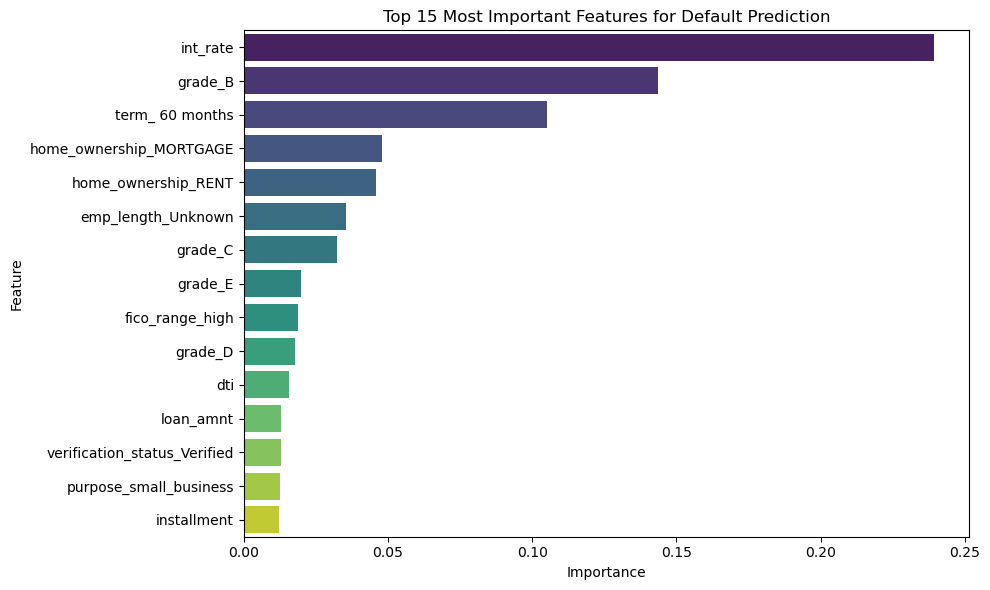

In [106]:
# -----------------------
# 4.2 Feature Importance Summary
# -----------------------

# Summary of feature importance
feat_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 15 Important Features:")
print(feat_imp.head(15))

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_imp.head(15), palette='viridis', legend=False)
plt.title("Top 15 Most Important Features for Default Prediction")
plt.tight_layout()
plt.show()
# =======================

In [108]:
# -----------------------
# 4.3 Overfitting Checks
# -----------------------
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Train set predictions
baseline_train_probs = baseline_model.predict_proba(X_train)[:, 1]
baseline_train_preds = (baseline_train_probs >= 0.5).astype(int)

tuned_train_probs = model.predict_proba(X_train)[:, 1]
tuned_train_preds = (tuned_train_probs >= 0.5).astype(int)

# Test set predictions
baseline_probs = baseline_model.predict_proba(X_test)[:, 1]
y_probs = model.predict_proba(X_test)[:, 1]  # for tuned model

# CV performance on training data
cv_baseline_auc = cross_val_score(baseline_model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)
cv_tuned_auc = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc', n_jobs=-1)

# Output
print("=== Overfitting Check ===")
print("Baseline Model:")
print(f"Train ROC AUC: {roc_auc_score(y_train, baseline_train_probs):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, baseline_probs):.4f}")
print(f"3-Fold CV ROC AUC (Train): {cv_baseline_auc.mean():.4f} ± {cv_baseline_auc.std():.4f}")

print("Tuned Model:")
print(f"Train ROC AUC: {roc_auc_score(y_train, tuned_train_probs):.4f}")
print(f"Test ROC AUC: {roc_auc_score(y_test, y_probs):.4f}")
print(f"3-Fold CV ROC AUC (Train): {cv_tuned_auc.mean():.4f} ± {cv_tuned_auc.std():.4f}")

=== Overfitting Check ===
Baseline Model:
Train ROC AUC: 0.7285
Test ROC AUC: 0.7278
3-Fold CV ROC AUC (Train): 0.7262 ± 0.0010
Tuned Model:
Train ROC AUC: 0.7444
Test ROC AUC: 0.7317
3-Fold CV ROC AUC (Train): 0.7295 ± 0.0011


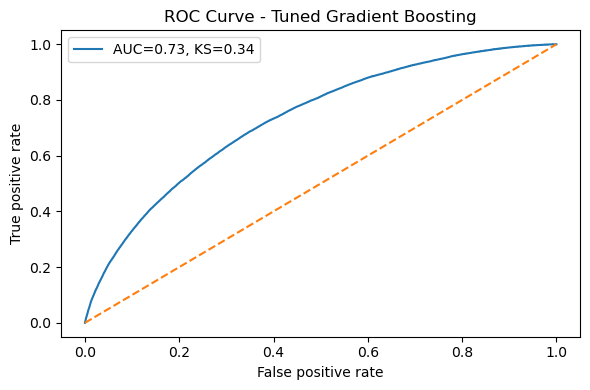

In [118]:
# ------------------------------------------
# 4.4 Classification Report - ROC Curve/KS Plots
# -----------------------------------------

# ROC Curve and KS Statistic for Tuned Model
predicted_probs = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, predicted_probs)
roc_auc = roc_auc_score(y_test, predicted_probs)
ks = np.max(tpr - fpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC={roc_auc:.2f}, KS={ks:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve - Tuned Gradient Boosting')
plt.legend()
plt.tight_layout()
plt.show()

Running learning curve analysis (this may take a while)...
Learning curve took 0.95 minutes


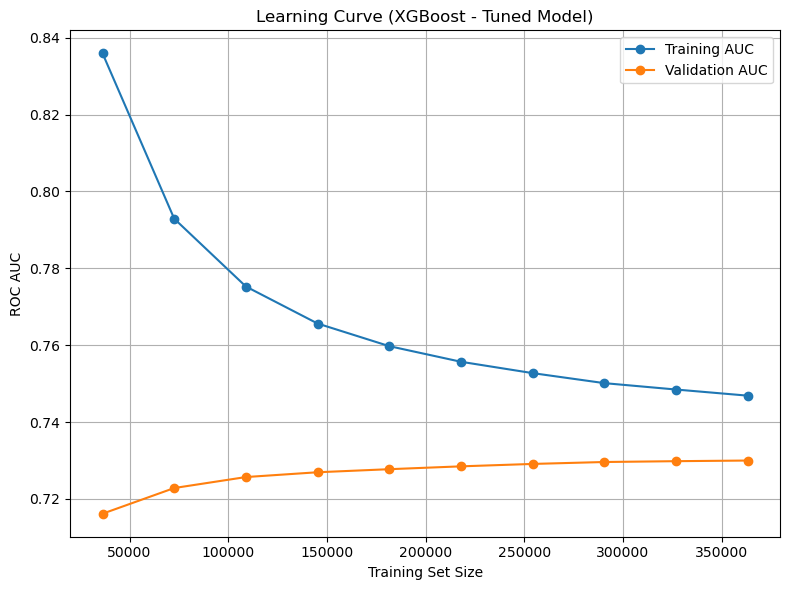

In [120]:
# -----------------------
# 4.5 Learning Curve Analysis
# -----------------------
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

print("Running learning curve analysis (this may take a while)...")
start = time.time()

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

end = time.time()
print(f"Learning curve took {(end - start)/60:.2f} minutes")

# Calculate means
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training AUC')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation AUC')
plt.title('Learning Curve (XGBoost - Tuned Model)')
plt.xlabel('Training Set Size')
plt.ylabel('ROC AUC')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# -----------------------
# 4.6 Actual Default Rate Comparison and Confusion Matrix
# -----------------------

from sklearn.metrics import confusion_matrix

# Predict probabilities and binary outcomes at threshold = 0.5
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_default = (y_probs >= 0.5).astype(int)

# Compare actual default rate vs predicted default rate
actual_default_rate = y_test.mean()
predicted_default_rate = y_pred_default.mean()

print("Actual default rate in test set: {:.2f}%".format(actual_default_rate * 100))
print("Predicted default rate (threshold = 0.5): {:.2f}%".format(predicted_default_rate * 100))

# Enhanced Confusion Matrix with Error Breakdown
conf_matrix = confusion_matrix(y_test, y_pred_default)
labels = ['True Negative\n(No Default)', 'False Positive',
          'False Negative', 'True Positive\n(Default)']
counts = [f"{value:,}" for value in conf_matrix.flatten()]
percentages = [f"{value:.1%}" for value in conf_matrix.flatten() / np.sum(conf_matrix)]

# Combine into labels for display
matrix_labels = [f"{label}\n{count}\n{percent}" for label, count, percent in zip(labels, counts, percentages)]
matrix_labels = np.array(matrix_labels).reshape(2, 2)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=matrix_labels, fmt="", cmap="Blues", cbar=False,
            xticklabels=["No Default", "Default"], yticklabels=["No Default", "Default"])
plt.title("Confusion Matrix with Error Breakdown")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.tight_layout()
plt.show()

Actual default rate in test set: 21.14%
Predicted default rate (threshold = 0.5): 41.61%


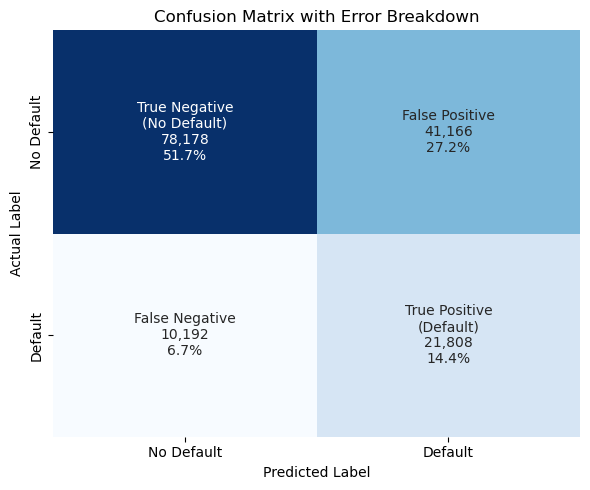

In [ ]:
#Overpredicting defaults - High predicted default rate vs Actual - Expected at 0.5 Threshold - Threshold Tuning Later

In [126]:
# -----------------------
# 4.7 Additional Evaluation Metrics (Precision, Recall, F1, ROC, KS)
# -----------------------

# Predict labels and probabilities
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

# Classification metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_probs)

# KS Statistic (max difference between TPR and FPR)
fpr, tpr, _ = roc_curve(y_test, y_probs)
ks = np.max(tpr - fpr)

# Print all metrics
print("=== Evaluation Metrics (Threshold = 0.5) ===")
print(f"Precision:      {precision:.4f}")
print(f"Recall:         {recall:.4f}")
print(f"F1 Score:       {f1:.4f}")
print(f"ROC AUC Score:  {auc:.4f}")
print(f"KS Statistic:   {ks:.4f}")


=== Evaluation Metrics (Threshold = 0.5) ===
Precision:      0.3463
Recall:         0.6815
F1 Score:       0.4592
ROC AUC Score:  0.7317
KS Statistic:   0.3373


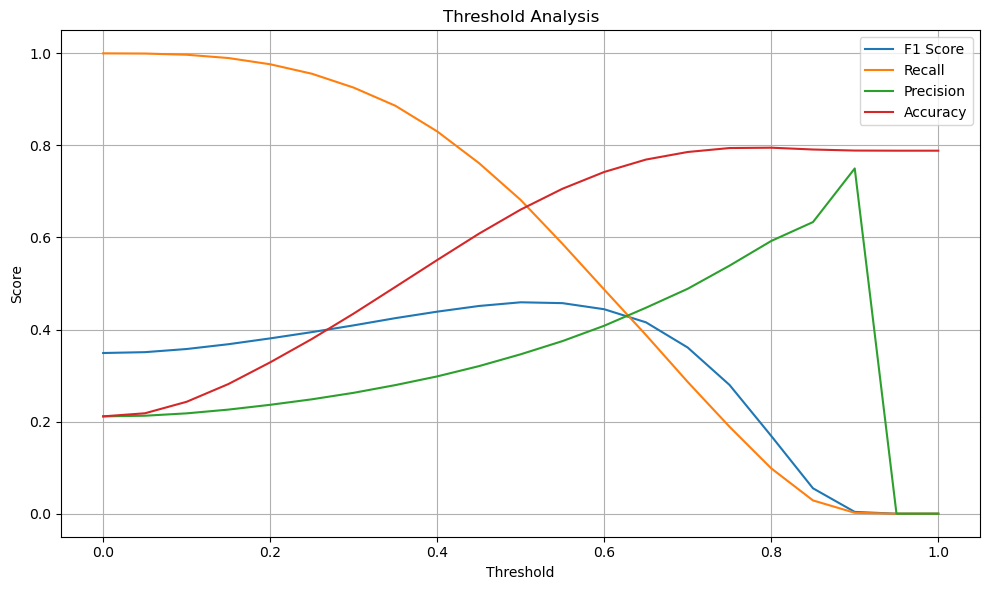

Optimal Threshold by F1 Score: 0.50
Threshold = Optimal F1 Threshold: 0.50
              precision    recall  f1-score   support

           0       0.88      0.66      0.75    119344
           1       0.35      0.68      0.46     32000

    accuracy                           0.66    151344
   macro avg       0.62      0.67      0.61    151344
weighted avg       0.77      0.66      0.69    151344



In [128]:
# =======================
# 5.1 Optimal Threshold Tuning
# =======================

from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, accuracy_score, classification_report

thresholds = np.arange(0.0, 1.05, 0.05)
f1_scores = []
recalls = []
precisions = []
accuracies = []

#Need to account for division by zero, since our model can predict zero defaults
for thresh in thresholds:
    preds = (y_probs >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))
    precisions.append(precision_score(y_test, preds, zero_division=0))
    accuracies.append(accuracy_score(y_test, preds))

# Plotting threshold vs F1/Recall/Precision
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Analysis")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold by F1 Score
optimal_thresh = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold by F1 Score: {optimal_thresh:.2f}")

# Apply optimal threshold
threshold = optimal_thresh
y_pred_thresh = (y_probs >= threshold).astype(int)

print(f"Threshold = Optimal F1 Threshold: {threshold:.2f}")
print(classification_report(y_test, y_pred_thresh, zero_division=0))


In [134]:
# -----------------------
# 5.2 Threshold Sensitivity Analysis (Low, Default, High)
# -----------------------
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve
)

thresholds_to_test = [0.3, 0.5, 0.7]

y_probs = model.predict_proba(X_test)[:, 1]

for thresh in thresholds_to_test:
    y_pred_thresh = (y_probs >= thresh).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    auc = roc_auc_score(y_test, y_probs)

    # KS statistic
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    ks = np.max(tpr - fpr)

    print(f"\n=== Evaluation Metrics (Threshold = {thresh:.2f}) ===")
    print(f"Precision:      {precision:.4f}")
    print(f"Recall:         {recall:.4f}")
    print(f"F1 Score:       {f1:.4f}")
    print(f"ROC AUC Score:  {auc:.4f}")
    print(f"KS Statistic:   {ks:.4f}")

#Trade-Off between Precision & Recall. For minimising defaults, better to focus on catching as many defaulters as possible ==> 
#Prioritise Recall ==> Lower Thresholds


=== Evaluation Metrics (Threshold = 0.30) ===
Precision:      0.2626
Recall:         0.9256
F1 Score:       0.4091
ROC AUC Score:  0.7317
KS Statistic:   0.3373

=== Evaluation Metrics (Threshold = 0.50) ===
Precision:      0.3463
Recall:         0.6815
F1 Score:       0.4592
ROC AUC Score:  0.7317
KS Statistic:   0.3373

=== Evaluation Metrics (Threshold = 0.70) ===
Precision:      0.4886
Recall:         0.2862
F1 Score:       0.3610
ROC AUC Score:  0.7317
KS Statistic:   0.3373


Selected Low-Risk Loan Portfolio Summary (Threshold < 0.2):
Total loans selected: 19277
Observed default rate in selected portfolio: 3.94%
Top N Loan Portfolio Summary:
Top 300 loans selected
Observed default rate: 1.33%
Top 10% Loan Portfolio Summary:
Loans selected: 15134
Observed default rate: 3.36%


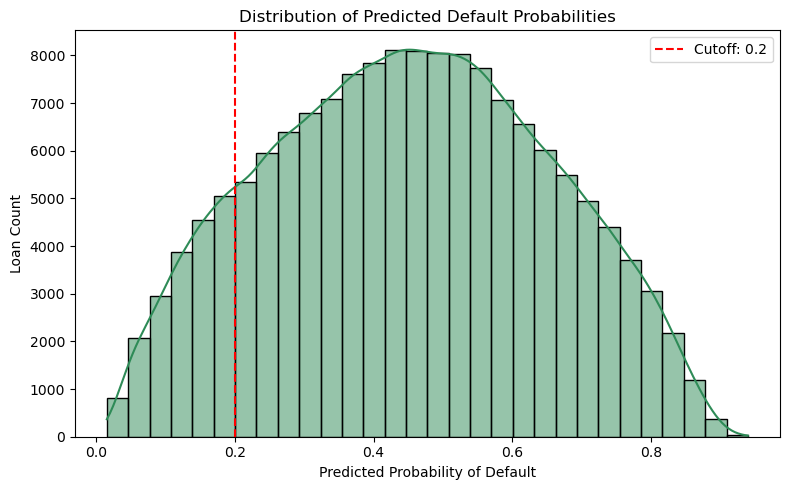

In [138]:
# =======================
# 6.1 Loan Portfolio Construction (Minimising Default - Option 1: Threshold-Based)
# =======================

# Construct a portfolio of loans predicted to have low risk of default
# Sort by predicted probability of default (ascending)
portfolio = X_test.copy()
portfolio['prob_default'] = y_probs
portfolio['actual_default'] = y_test

# Define cutoff for low-risk (e.g. probability of default < 0.2)
portfolio_selected = portfolio[portfolio['prob_default'] < 0.2]

# Portfolio summary
print("Selected Low-Risk Loan Portfolio Summary (Threshold < 0.2):")
print(f"Total loans selected: {len(portfolio_selected)}")
print(f"Observed default rate in selected portfolio: {portfolio_selected['actual_default'].mean() * 100:.2f}%")

# Option 2: Top N safest loans
N = 300
portfolio_top_n = portfolio.sort_values(by='prob_default').head(N)
print("Top N Loan Portfolio Summary:")
print(f"Top {N} loans selected")
print(f"Observed default rate: {portfolio_top_n['actual_default'].mean() * 100:.2f}%")

# Option 3: Top X% safest loans
top_percent = 0.10
n_select = int(len(portfolio) * top_percent)
portfolio_top_pct = portfolio.sort_values(by='prob_default').head(n_select)
print("Top 10% Loan Portfolio Summary:")
print(f"Loans selected: {n_select}")
print(f"Observed default rate: {portfolio_top_pct['actual_default'].mean() * 100:.2f}%")

# Distribution of predicted default probabilities
plt.figure(figsize=(8,5))
sns.histplot(portfolio['prob_default'], bins=30, kde=True, color='seagreen')
plt.axvline(0.2, color='red', linestyle='--', label='Cutoff: 0.2')
plt.title("Distribution of Predicted Default Probabilities")
plt.xlabel("Predicted Probability of Default")
plt.ylabel("Loan Count")
plt.legend()
plt.tight_layout()
plt.show()

In [140]:
# =======================
# 6.2 Top Risky and Safest Loans Based on Predicted Default Probabilities
# =======================

# Top 10 most risky loans (highest probability of default)
print("\nTop 10 Most Risky Loans (Highest Predicted Default Probabilities):")
print(
    portfolio.sort_values(by='prob_default', ascending=False)
    [["loan_amnt", "int_rate", "prob_default"]]
    .head(10)
)

# Top 10 safest loans (lowest probability of default)
print("\nTop 10 Safest Loans (Lowest Predicted Default Probabilities):")
print(
    portfolio.sort_values(by='prob_default', ascending=True)
    [["loan_amnt", "int_rate", "prob_default"]]
    .head(10)
)



Top 10 Most Risky Loans (Highest Predicted Default Probabilities):
        loan_amnt  int_rate  prob_default
633824    21000.0     23.99      0.940019
478694    16450.0     22.45      0.938678
83141     35000.0     25.99      0.936592
809794    15000.0     30.17      0.929183
522720    11000.0     28.99      0.926036
793837    20000.0     30.65      0.925571
490180    30000.0     27.34      0.924416
97428     10850.0     21.67      0.924321
477900    19850.0     28.67      0.924177
551162    12950.0     24.11      0.923394

Top 10 Safest Loans (Lowest Predicted Default Probabilities):
         loan_amnt  int_rate  prob_default
267989     25400.0      6.89      0.015087
362583      1500.0      6.24      0.015881
799903      1000.0      5.32      0.017327
354998      7200.0      5.32      0.017655
828584      4600.0      5.32      0.018093
953074     11000.0      6.11      0.018250
465220      4000.0      5.32      0.018390
468809      5000.0      5.32      0.018623
24638       5500.0  

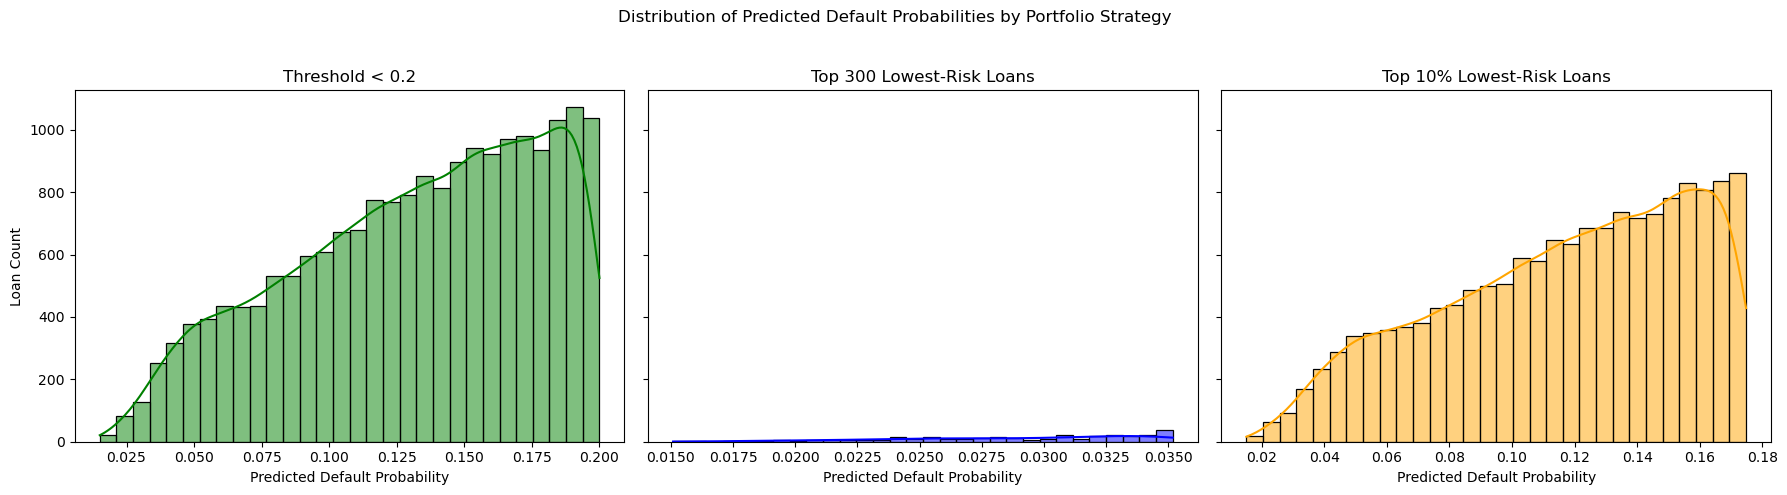

Portfolio Strategy Comparison:
          Portfolio Strategy  Loans Selected  Observed Default Rate (%)
0            Threshold < 0.2           19277                   3.937335
1  Top 300 Lowest-Risk Loans             300                   1.333333
2  Top 10% Lowest-Risk Loans           15134                   3.356680


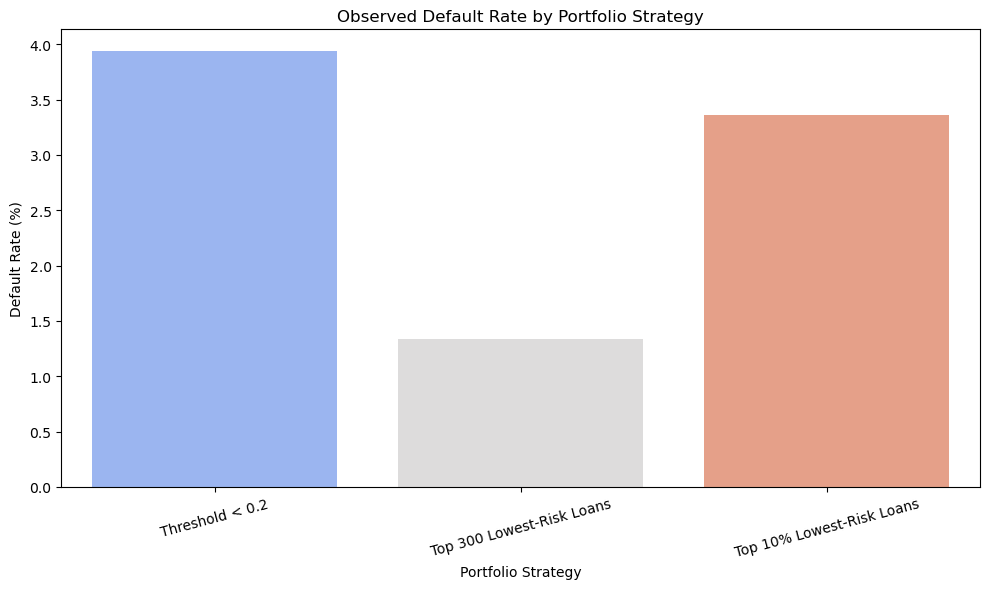

In [142]:
# =======================
# 6.3 Portfolio Comparison Analysis
# =======================

# Distribution plots for each portfolio strategy
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

sns.histplot(portfolio_selected['prob_default'], bins=30, kde=True, ax=axs[0], color='green')
axs[0].set_title('Threshold < 0.2')
axs[0].set_xlabel('Predicted Default Probability')
axs[0].set_ylabel('Loan Count')

sns.histplot(portfolio_top_n['prob_default'], bins=30, kde=True, ax=axs[1], color='blue')
axs[1].set_title(f'Top {N} Lowest-Risk Loans')
axs[1].set_xlabel('Predicted Default Probability')

sns.histplot(portfolio_top_pct['prob_default'], bins=30, kde=True, ax=axs[2], color='orange')
axs[2].set_title(f'Top {int(top_percent*100)}% Lowest-Risk Loans')
axs[2].set_xlabel('Predicted Default Probability')

plt.suptitle('Distribution of Predicted Default Probabilities by Portfolio Strategy')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Note: These plots help illustrate the concentration of safer loans in each strategy.
# The threshold-based method tends to include more extremely low-risk loans,
# while the top-N and top-% methods may capture slightly broader risk ranges depending on the test set distribution.
# =======================

# Create a comparison summary
portfolio_comparison = pd.DataFrame({
    'Portfolio Strategy': ['Threshold < 0.2', f'Top {N} Lowest-Risk Loans', f'Top {int(top_percent*100)}% Lowest-Risk Loans'],
    'Loans Selected': [len(portfolio_selected), len(portfolio_top_n), len(portfolio_top_pct)],
    'Observed Default Rate (%)': [
        portfolio_selected['actual_default'].mean() * 100,
        portfolio_top_n['actual_default'].mean() * 100,
        portfolio_top_pct['actual_default'].mean() * 100
    ]
})

print("Portfolio Strategy Comparison:")
print(portfolio_comparison)

# Bar plot for visual comparison
plt.figure(figsize=(10,6))
sns.barplot(data=portfolio_comparison, x='Portfolio Strategy', y='Observed Default Rate (%)', hue='Portfolio Strategy', palette='coolwarm', legend=False)
plt.title("Observed Default Rate by Portfolio Strategy")
plt.ylabel("Default Rate (%)")
plt.xlabel("Portfolio Strategy")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
